<a href="https://colab.research.google.com/github/AcidCannon/CMPUT466-Mini-project/blob/master/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [219]:
# mount google drive to save checkpoints
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
config = {}
config['training_size'] = 50000
config['test_size'] = 5000
config['validation_size'] = 5000
config['training_shuffle'] = True
config['test_shuffle'] = False
config['validation_shuffle'] = True
config['num_of_classes'] = 10
config['device'] = 'gpu'
config['algorithm'] = 'Convolutional Neural Network'
config['training_batch_size'] = 64
config['validation_batch_size'] = 64
config['test_batch_size'] = config['test_size']
config['learning_rate'] = 0.0001
config['weight_decay'] = 0.001
config['best_epoch'] = -1
config['best_accuracy'] = 0
config['number_of_epochs'] = 5
config['display_progress_per_epoch'] = 1
config['mode'] = 'fresh_start' # 'fresh_start' 'load_and_train' 'test'
config['tracking_progress'] = True

In [0]:
def load_data(config):
  CIFAR10_training_set = datasets.CIFAR10('data', train=True, download=True, transform=transforms.Compose([
                                          transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
  
  CIFAR10_test = datasets.CIFAR10('data', train=False, download=True, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
  
  CIFAR10_training_set = torch.utils.data.Subset(CIFAR10_training_set, range(0, config['training_size']))
  CIFAR10_test_set = torch.utils.data.Subset(CIFAR10_test, range(0, config['test_size']))
  CIFAR10_validation_set = torch.utils.data.Subset(CIFAR10_test, range(config['test_size'], config['test_size'] + config['validation_size']))

  training_dataloader = torch.utils.data.DataLoader(CIFAR10_training_set, batch_size=config['training_batch_size'], shuffle=config['training_shuffle'])
  validation_dataloader = torch.utils.data.DataLoader(CIFAR10_validation_set, batch_size=config['validation_batch_size'], shuffle=config['validation_shuffle'])
  test_dataloader = torch.utils.data.DataLoader(CIFAR10_test_set, batch_size=config['test_batch_size'], shuffle=config['test_shuffle'])
  return training_dataloader, test_dataloader, validation_dataloader

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 18, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(18, 18, kernel_size=5, padding=2)
    # we need skip connection, so remain size
    self.conv5 = nn.Conv2d(18, 18, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(18, 48, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(48, 48, kernel_size=5, padding=2)
    # we need skip connection, so remain size
    self.conv6 = nn.Conv2d(48, 48, kernel_size=5, padding=2)
    self.bn1 = nn.BatchNorm2d(18)
    self.bn2 = nn.BatchNorm2d(48)
    self.fc1 = nn.Linear(48*8*8, 48)
    self.fc2 = nn.Linear(48, config['num_of_classes'])
    self.drop = nn.Dropout(0.5)
  
  def forward(self, x):
    x = F.leaky_relu(self.conv1(x))
    res = x
    x = F.leaky_relu(self.conv2(x))
    x = self.conv5(x)
    x += res
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = self.bn1(x)
    x = F.leaky_relu(x)
    x = F.leaky_relu(self.conv3(x))
    res = x
    x = F.leaky_relu(self.conv4(x))
    x = self.conv6(x)
    x += res
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = self.bn2(x)
    x = F.leaky_relu(x)
    x = x.view(-1, 48*8*8)
    x = F.leaky_relu(self.fc1(x))
    x = self.drop(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [0]:
def train(training_dataloader, test_dataloader, config, device, model=None):
  if not model:
    model = Net().to(device)
  
  loss_function = F.cross_entropy
  optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay = config['weight_decay'])

  for epoch in range(1, config['number_of_epochs']+1):
    # TRAIN
    model.train()
    for idx, (data, target) in enumerate(training_dataloader):
      data = data.to(device)
      target = target.to(device)
      # set gradient to be zero
      optimizer.zero_grad()
      # forward propagation
      output = model(data)
      # compute loss
      loss = loss_function(output, target)
      # backward propagation
      loss.backward()
      # weight updation
      optimizer.step()
    # VALIDATION
    if epoch % config['display_progress_per_epoch'] == 0:
      model.eval()
      validation_loss = 0
      correct = 0
      # no gradients needed since we are doing validation
      with torch.no_grad():
        for idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device)
          target = target.to(device)
          # predict / forward propagation
          output = model(data)
          loss = loss_function(output, target)
          # find target label
          _, predicted = torch.max(output.data, 1)
          correct += (predicted == target).sum()
          validation_loss += loss.item()
      accuracy = 100*float(correct)/len(test_dataloader.dataset)
      print("Epoch: {}.\tAvg.loss: {}.\tAccuracy: {}%.".format(epoch, validation_loss/len(test_dataloader.dataset), accuracy))
      # checkpoint saving strategy: mode
      if config['mode'] == 'fresh_start' or config['mode'] == 'load_and_train':
        if accuracy > config['best_accuracy']:
          config['best_epoch'] = epoch
          config['best_accuracy'] = accuracy
          torch.save(model.state_dict(), '/content/gdrive/My Drive/checkpoints/checkpoint.pth')
          print("Checkpoint saved.\tAt epoch: {}.\tWith accuracy: {}%.".format(epoch, accuracy))
          if config['tracking_progress']:
            f = open('/content/gdrive/My Drive/checkpoints/progress.csv', 'a+')
            f.write('{},{}\n'.format(epoch, accuracy))
            f.close()
      elif config['mode'] == 'test':
        pass

In [0]:
def test(model, test_dataloader, device):
  correct = 0
  total = len(test_dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == target).sum().item()
  return 100.*correct/total, correct, total

In [0]:
def run(config):
  print('Training set size: {}x{}.'.format(config['training_size'], '3x32x32'))
  print('Validation set size: {}x{}.'.format(config['validation_size'], '3x32x32'))
  print('Test set size: {}x{}.'.format(config['test_size'], '3x32x32'))
  print('Using algorithm: {}.'.format(config['algorithm']))

  if config['device'] != 'cpu' and torch.cuda.is_available():
    config['device'] = torch.device('cuda')
    print('Using GPU: {}.'.format(torch.cuda.get_device_name(0)))
  else:
    config['device'] = torch.device('cpu')
    print('Using CPU.')

  print("Running...")

  training_dataloader, test_dataloader, validation_dataloader = load_data(config)
  
  if config['mode'] == 'fresh_start':
    train(training_dataloader, validation_dataloader, config, config['device'])
    model = Net().to(config['device'])
    model.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/checkpoint.pth'))
    model.eval()
    test_accuracy, correct, total = test(model, test_dataloader, config['device'])
    print("Test accuracy: {}%.\tCorrect: {}.\tTotal: {}.".format(test_accuracy, correct, total))
  elif config['mode'] == 'load_and_train':
    model = Net().to(config['device'])
    model.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/checkpoint.pth'))
    train(training_dataloader, validation_dataloader, config, config['device'], model)
    model.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/checkpoint.pth'))
    model.eval()
    test_accuracy, correct, total = test(model, test_dataloader, config['device'])
    print("Test accuracy: {}%.\tCorrect: {}.\tTotal: {}.".format(test_accuracy, correct, total))
  elif config['mode'] == 'test':
    model = Net().to(config['device'])
    model.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/checkpoint.pth'))
    model.eval()
    test_accuracy, correct, total = test(model, test_dataloader, config['device'])
    print("Test accuracy: {}%.\tCorrect: {}.\tTotal: {}.".format(test_accuracy, correct, total))

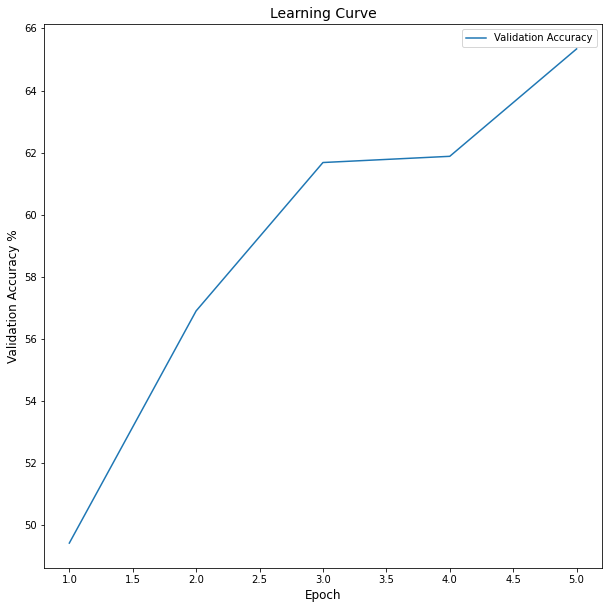

In [231]:
# The learning curve of the validation accuracy
dataframe = pd.read_csv('/content/gdrive/My Drive/checkpoints/progress.csv', header=None)
plt.figure(figsize=(10, 10))
plt.title("Learning Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Accuracy %", fontsize=12)
plt.plot(dataframe.values[:, 0], dataframe.values[:, 1], label="Validation Accuracy")
plt.legend()
plt.savefig('acc.jpg')

In [238]:
training_dataloader, test_dataloader, validation_dataloader = load_data(config)
for i, (images, labels) in enumerate(training_dataloader):
    print(images.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])


KeyboardInterrupt: ignored